# 📚 ДЗ №2: Работа с данными для LLM

## 🎯 Цель задания
После выполнения задания вы сможете:
- Предобрабатывать русскоязычные текстовые данные для LLM
- Работать с готовыми моделями HuggingFace для анализа тональности и NER
- Создавать эффективные промпты для LLM API
- Сравнивать качество работы разных подходов к анализу текста
- Формировать датасеты в формате instruction-following для fine-tuning
- Сохранять данные в правильных форматах для обучения LLM

## 📝 Структура задания
- **Часть 1** (35% оценки): Предобработка данных и работа с готовыми моделями
- **Часть 2** (35% оценки): LLM API и prompt engineering
- **Часть 3** (20% оценки): Подготовка данных для fine-tuning LLM
- **Часть 4** (10% оценки): Сравнительный анализ и визуализация

## ⚡ Критерии оценки
- Качество предобработки данных: 25%
- Корректность работы с готовыми моделями: 20%
- Эффективность промптов для LLM: 25%
- Правильность подготовки данных для fine-tuning: 20%
- Качество сравнительного анализа: 10%


## 🔧 Установка зависимостей

Установим необходимые библиотеки для работы с данными, готовыми моделями и LLM API.


In [54]:
from pandas.core.interchange.dataframe_protocol import DataFrame
%pip install pandas numpy matplotlib seaborn
%pip install transformers torch
%pip install openai>=1.0.0  # Для работы с OpenAI API
%pip install datasets
%pip install pymorphy2



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
zsh:1: 1.0.0 not found
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from typing import List, Dict, Tuple
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

pd.options.display.max_rows = 100
pd.set_option("display.max_rows", 100)

print("Библиотеки загружены успешно!")



Библиотеки загружены успешно!


## 📊 Часть 1: Предобработка данных и готовые модели (35% оценки)

### Задание 1.1: Анализ "грязного" датасета

Проанализируем реалистичный датасет с типичными проблемами: опечатки, разные регистры, лишние пробелы, эмодзи.


In [8]:
# Создаем "грязный" датасет с типичными проблемами реальных данных
# Включаем сложные случаи для демонстрации преимуществ LLM
raw_reviews = [
    # Простые случаи
    "отличный iphone 14 PRO!!!  купил в магазине  apple на тверской 😊. Камера супер#positive",
    "УЖАСНОЕ обслуживание в сбербанке на красной площади.. менеджер иван петров вобще не помог(#negative",

    # Сарказм и ирония (сложно для классических моделей)
    "Спасибо огромное сотрудникам МТС за то что 3 часа держали меня в очереди! Просто восхитительно 👏#negative",
    "Какой замечательный сервис в Пятерочке - касса сломалась прямо передо мной, а персонал даже не извинился#negative",

    # Смешанные эмоции
    "iPhone 13 хороший телефон, но цена кусается. В целом доволен покупкой в re:Store#neutral",
    "Ресторан Белуга красивый и атмосфера приятная, но официант Максим был невнимателен#negative",

    # Сложная структура предложений
    "Хотя Tesla Model Y и дорогая машина, и сервис в Рольф Премиум иногда подводит, но в целом я очень доволен покупкой#positive",
    "Не могу сказать что отель Ритц-Карлтон плохой, просто ожидал большего за такие деньги#neutral",

    # Контекстно-зависимые случаи
    "Заказал доставку в Яндекс.Еде из ресторана Дача на Рублевке - привезли холодное, но курьер Андрей был вежливый#positive",
    "MacBook Pro 16 работает как часы уже год, покупал в iStore на Арбате у консультанта Елены#positive",

    # Неоднозначные случаи
    "Сходил в кинотеатр Октябрь посмотреть новый фильм Marvel - ну такое себе, но попкорн вкусный был#neutral",
    "Обслуживание в банке ВТБ на Тверской оставляет желать лучшего, хотя менеджер Ольга старалась помочь#negative",

    # Сложные именованные сущности
    "Купил новый Samsung Galaxy S24 Ultra в DNS на Ленинском проспекте, консультант Дмитрий Иванович всё объяснил#neutral",
    "Ужинал в ресторане White Rabbit на Смоленской площади - шеф-повар Владимир Мухин превзошел ожидания#positive",

    # Опечатки и сленг
    "норм телек LG купил в эльдорадо, продавец норм чел был, всё рассказал про функции#positive"
]

# Проблемы:
#     - повторяющиеся знаки препинания
#     - ошибки
#     - эмодзи
#     - названия с использованием знаков Яндекс.Еде, re:Store
#     - эмоции через знаки

df = pd.DataFrame()
df['text'] = None
df['mark'] = None

for review in raw_reviews:

    review_text, review_mark = review.split("#")

    df = pd.concat([df, pd.DataFrame({'text': [review_text], 'mark': [review_mark]})], ignore_index=True)


# Анализ структуры данных
print("Структура данных:")
print(f"Количество отзывов: {df.shape[0]}")
print(f"Колонки: {list(df.columns)}")

print("\nДлина текстов отзывов:")
df["text_length"] = df["text"].str.len()
print(f"Средняя длина: {df['text_length'].mean():.1f} символов")
print(f"Минимальная: {df['text_length'].min()} символов")
print(f"Максимальная: {df['text_length'].max()} символов")

print(f"Загружено {df.shape[0]} отзывов из общего списка:")

df.head()



Структура данных:
Количество отзывов: 15
Колонки: ['text', 'mark']

Длина текстов отзывов:
Средняя длина: 94.1 символов
Минимальная: 78 символов
Максимальная: 114 символов
Загружено 15 отзывов из общего списка:


,text,mark,text_length
0,отличный iphone 14 PRO!!! купил в магазине a...,positive,78
1,УЖАСНОЕ обслуживание в сбербанке на красной пл...,negative,90
2,Спасибо огромное сотрудникам МТС за то что 3 ч...,negative,96
3,Какой замечательный сервис в Пятерочке - касса...,negative,104
4,"iPhone 13 хороший телефон, но цена кусается. В...",neutral,80


### Задание 1.2: Очистка и нормализация данных


In [9]:
def clean_text(text: str) -> str:
    if not text or pd.isna(text):
        return ""

    text = re.sub(r"[^\w\s\-.,!?;:()]", "", text)

    text = re.sub(r"\s+", " ", text)
    text = text.strip()

    text = re.sub(r"[.]{2,}", ".", text)
    text = re.sub(r"[!]{2,}", "!", text)
    text = re.sub(r"[?]{2,}", "?", text)

    if text:
        text = text[0].upper() + text[1:].lower()

    return text

df["cleaned_text"] = df["text"].apply(clean_text)

print(f"\nСредняя длина до очистки: {df['text'].str.len().mean():.1f}")
print(f"Средняя длина после очистки: {df['cleaned_text'].str.len().mean():.1f}")



Средняя длина до очистки: 94.1
Средняя длина после очистки: 93.5


### Задание 1.3: Использование готовых моделей HuggingFace


In [57]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline


import time


# TODO: Загрузите готовые модели HuggingFace для анализа тональности и NER
# Исследуйте HuggingFace Hub и найдите подходящие русскоязычные модели для:
# - Анализа тональности (sentiment analysis)
# - Извлечения именованных сущностей (NER)
#
# Используйте функцию pipeline() из библиотеки transformers
# Обратите внимание на параметры модели и токенизатора

# Ваш код для загрузки моделей:

sentiment_model = pipeline(
    "sentiment-analysis",
    model="blanchefort/rubert-base-cased-sentiment-rusentiment",
    return_all_scores=True
)

def sentiment_pipeline(text: str):

    label_mapping = {
        "POSITIVE": "positive",
        "NEGATIVE": "negative",
        "NEUTRAL": "neutral"
    }

    sentiment = ''

    result = sentiment_model(text)

    if result and len(result[0]) > 0:
        best_sentiment = max(result[0], key=lambda x: x["score"])

        sentiment = label_mapping.get(best_sentiment["label"].upper(), best_sentiment["label"].lower())

    return sentiment


def analyze_with_huggingface(texts: List[str]) -> List[Dict]:
    """
    Анализ текстов с помощью готовых моделей HuggingFace
    """

    ner_model_id = "r1char9/ner-rubert-tiny-RuNews"

    label2id = {
        'O': 0,
        'B-GEOPOLIT': 1, 'I-GEOPOLIT': 2,
        'B-MEDIA': 3,    'I-MEDIA': 4,
        'B-LOC': 5,      'I-LOC': 6,
        'B-ORG': 7,      'I-ORG': 8,
        'B-PER': 9,      'I-PER': 10
    }
    id2label = {v: k for k, v in label2id.items()}

    ner_model = AutoModelForTokenClassification.from_pretrained(
        ner_model_id,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )

    ner_pipeline = pipeline(
        "ner",
        model=ner_model,
        tokenizer=AutoTokenizer.from_pretrained(ner_model_id),
        aggregation_strategy="simple"
    )

    output = []

    for text in texts:

        start_time = time.time()

        sentiment = sentiment_pipeline(text)

        sentiment_processing_time = time.time() - start_time


        start_time = time.time()

        ner_entity = ner_pipeline(text)
        entity = []

        for ner in ner_entity:
            entity.append(ner['word'])

        ner_processing_time = time.time() - start_time

        output.append({
            'text': text,
            'sentiment': sentiment,
            'sentiment_time': sentiment_processing_time,
            'entity': entity,
            'entity_time': ner_processing_time
        })

    return output


df_hugg = pd.DataFrame(analyze_with_huggingface(df["cleaned_text"]))

display(df_hugg)


Device set to use cpu
Device set to use cpu


,text,sentiment,sentiment_time,entity,entity_time
0,Отличный iphone 14 pro! купил в магазине apple...,positive,0.043065,[],0.003540
1,Ужасное обслуживание в сбербанке на красной пл...,negative,0.029696,[],0.002358
2,Спасибо огромное сотрудникам мтс за то что 3 ч...,positive,0.022210,[],0.002276
3,Какой замечательный сервис в пятерочке - касса...,negative,0.021328,[],0.003013
4,"Iphone 13 хороший телефон, но цена кусается. в...",neutral,0.023033,[],0.002247
5,"Ресторан белуга красивый и атмосфера приятная,...",negative,0.022828,[],0.002191
6,"Хотя tesla model y и дорогая машина, и сервис ...",positive,0.028364,[tesla],0.003093
7,"Не могу сказать что отель ритц-карлтон плохой,...",neutral,0.021769,[],0.002244
8,Заказал доставку в яндекс.еде из ресторана дач...,neutral,0.021848,[],0.002529
9,"Macbook pro 16 работает как часы уже год, поку...",neutral,0.022743,"[Macbook, is]",0.002339


## 🤖 Часть 2: LLM API и Prompt Engineering (35% оценки)

### Задание 2.1: Создание эффективных промптов


In [23]:

# вместо функции create_prompts_for_llm  сделал свою с указанием system
# в качестве llm используем яндекс gpt

def getOpenAiAnswerByPrompt(system_content: str, text: str) -> List[Dict]:

    import os
    import openai

    YANDEX_CLOUD_FOLDER = os.getenv("folder_id")
    YANDEX_CLOUD_API_KEY = os.getenv("ya_token")

    client = openai.OpenAI(
        api_key=YANDEX_CLOUD_API_KEY,
        base_url="https://llm.api.cloud.yandex.net/v1"
    )

    response = client.chat.completions.create(
        model=f"gpt://{YANDEX_CLOUD_FOLDER}/yandexgpt/latest",
        messages=[
            {"role": "system", "content": system_content},
            {"role": "user", "content": text}
        ],
        max_tokens=1000,
        temperature=0.1,  # делаем меньше температуру чтобы модель не придумывала
        stream=True
    )

    ai_result = []

    for chunk in response:
        if chunk.choices[0].delta.content is not None:

            for row in chunk.choices[0].delta.content.splitlines():
                ai_result.append(row)

    return list(filter(None, ai_result))


In [37]:

# делаем общий DataFrame

df_common = df_hugg

df_common['llm_sentiment'] = None
df_common['llm_sentiment_time'] = None
df_common['llm_entity'] = None
df_common['llm_entity_time'] = None

df_common.head()


,text,sentiment,sentiment-time,entity,entity-time,llm_sentiment,llm_sentiment_time,llm_entity,llm_entity_time
0,Отличный iphone 14 pro! купил в магазине apple...,positive,0.040344,[],0.003631,None,None,None,None
1,Ужасное обслуживание в сбербанке на красной пл...,negative,0.032578,[],0.003080,None,None,None,None
2,Спасибо огромное сотрудникам мтс за то что 3 ч...,positive,0.025658,[],0.002266,None,None,None,None
3,Какой замечательный сервис в пятерочке - касса...,negative,0.022911,[],0.002294,None,None,None,None
4,"Iphone 13 хороший телефон, но цена кусается. в...",neutral,0.021334,[],0.002264,None,None,None,None


In [49]:

# Промпт для Анализа тональности (sentiment analysis)
system_content_sentiment = """
Ты — система анализа тональности. Твоя задача — классифицировать эмоциональный тон предоставленного текста на одну из следующих категорий:
- **positive** (позитивные эмоции, удовлетворение, оптимизм)
- **negative** (негативные эмоции, недовольство, пессимизм)
- **neutral** (отсутствие чёткого эмоционального оттенка)

В ответе должен быть только 1 класс из списка [positive, negative, neutral]


Пример:
Вход: "Я в восторге от этого продукта! Он изменил мою жизнь."
Выход: positive

Вход: "Этот сервис был ужасен и абсолютно бесполезен."
Выход: negative

Вход: "Заседание началось в 10 часов."
Выход: neutral
"""


for idx in df_common.index:
    start_time = time.time()

    result = getOpenAiAnswerByPrompt(system_content=system_content_sentiment, text=df_common.loc[idx]['text'])

    print(result)

    processing_time = time.time() - start_time

    df_common.loc[idx, 'llm_sentiment'] = result[0]
    df_common.loc[idx, 'llm_sentiment_time'] = processing_time



['positive']
['negative']
['negative']
['negative']
['positive']
['neutral']
['positive']
['negative']
['neutral', '\u200b']
['positive']
['neutral']
['negative']
['neutral', '\u200b']
['positive']
['positive']


In [50]:
# Промпт для извлечения именованных сущностей (NER)
system_content_ner = """
Ты — система распознавания именованных сущностей. Твоя задача — выделить все именованные сущности в предоставленном тексте. Найденные сущности очисти от лишних пробелов.

В ответе должна быть только сущность, без специальных символов.

Пример:
Вход: "Apple Inc. была основана в 1976 году в Калифорнии Стивом Джобсом."
Выход:
Apple Inc.
1976
Калифорния
Стив Джобс
"""


for idx in df_common.index:
    start_time = time.time()

    result = getOpenAiAnswerByPrompt(system_content=system_content_ner, text=df_common.loc[idx]['text'])

    print(result)

    processing_time = time.time() - start_time

    df_common.loc[idx, 'llm_entity'] = result[0]
    df_common.loc[idx, 'llm_entity_time'] = processing_time



['iphone', ' 14 pro', 'apple', 'Тверская']
['Сбербанк', 'Красная площадь', 'Иван Петров']
['МТС', '3 часа']
['Пя', 'терочка']
['Iphone', ' 13', 're:store']
['Бе', 'луга', 'Максим']
['Tesla', ' Model Y', 'Рольф Премиум']
['Рит', 'ц-Карлтон']
['Яндекс', ' Еда', 'Дача на Рублевке', 'Андрей']
['Mac', 'book pro 16', 'год', 'istore', 'Арбат', 'Елена']
['Октябрь', 'Marvel']
['ВТБ', 'Тверская', 'Ольга']
['samsung', ' galaxy s24 ultra', 'dns', 'ленинский проспект', 'дмитрий иванович']
['white', ' rabbit', 'Смоленская площадь', 'Владимир Мухин']
['LG', 'Эльдорадо']


### Задание 2.2: Сравнение результатов HuggingFace vs LLM


In [51]:
# TODO: Сравните результаты HuggingFace моделей с LLM на одних и тех же текстах

# Выводы:
#
#     llm намного полнее и правильнее выполнила все задания чем скачаныя модели с huggface, но выполнение задания потребовало намного больше времени и финансовых затрат


df_common.head()

,text,sentiment,sentiment-time,entity,entity-time,llm_sentiment,llm_sentiment_time,llm_entity,llm_entity_time
0,Отличный iphone 14 pro! купил в магазине apple...,positive,0.040344,[],0.003631,positive,0.332258,iphone,0.812873
1,Ужасное обслуживание в сбербанке на красной пл...,negative,0.032578,[],0.003080,negative,0.266273,Сбербанк,0.289954
2,Спасибо огромное сотрудникам мтс за то что 3 ч...,positive,0.025658,[],0.002266,negative,0.251992,МТС,0.322196
3,Какой замечательный сервис в пятерочке - касса...,negative,0.022911,[],0.002294,negative,0.259796,Пя,0.280089
4,"Iphone 13 хороший телефон, но цена кусается. в...",neutral,0.021334,[],0.002264,positive,0.241562,Iphone,0.33549


## 📚 Часть 3: Подготовка данных для Fine-tuning LLM (20% оценки)

### Задание 3.1: Создание instruction-following датасета


In [61]:
### Задание 2.3: Анализ сложных случаев

# Выберем специально сложные примеры для демонстрации преимуществ LLM
complex_cases = [
    "Спасибо огромное сотрудникам МТС за то что 3 часа держали меня в очереди! Просто восхитительно 👏",
    "iPhone 13 хороший телефон, но цена кусается. В целом доволен покупкой в re:Store",
    "Хотя Tesla Model Y и дорогая машина, и сервис в Рольф Премиум иногда подводит, но в целом я очень доволен покупкой",
    "норм телек LG купил в эльдорадо, продавец норм чел был, всё рассказал про функции"
]

print("Анализ сложных случаев:")
print("=" * 60)

# TODO: Сравните результаты HuggingFace и OpenAI на сложных случаях
for i, text in enumerate(complex_cases):
    print(f"\nПример {i+1}: {text}")

    hf_result = sentiment_pipeline(text)
    openai_result = getOpenAiAnswerByPrompt(system_content=system_content_sentiment, text=text)[0]
    print(f"HuggingFace: {hf_result}")
    print(f"OpenAI: {openai_result}")





Анализ сложных случаев:

Пример 1: Спасибо огромное сотрудникам МТС за то что 3 часа держали меня в очереди! Просто восхитительно 👏
HuggingFace: positive
OpenAI: negative

Пример 2: iPhone 13 хороший телефон, но цена кусается. В целом доволен покупкой в re:Store
HuggingFace: neutral
OpenAI: positive

Пример 3: Хотя Tesla Model Y и дорогая машина, и сервис в Рольф Премиум иногда подводит, но в целом я очень доволен покупкой
HuggingFace: positive
OpenAI: positive

Пример 4: норм телек LG купил в эльдорадо, продавец норм чел был, всё рассказал про функции
HuggingFace: neutral
OpenAI: positive


In [76]:
### Задание 2.4: Количественное сравнение точности

# Создаем расширенный набор для тестирования с правильными ответами
test_cases_with_labels = [
    # Сарказм и ирония - должны быть NEGATIVE
    ("Спасибо огромное сотрудникам МТС за то что 3 часа держали меня в очереди! Просто восхитительно 👏", "NEGATIVE"),
    ("Какой замечательный сервис в Пятерочке - касса сломалась прямо передо мной, а персонал даже не извинился", "NEGATIVE"),

    # Смешанные эмоции - должны быть NEUTRAL или зависеть от преобладающего тона
    ("iPhone 13 хороший телефон, но цена кусается. В целом доволен покупкой в re:Store", "NEUTRAL"),
    ("Ресторан Белуга красивый и атмосфера приятная, но официант Максим был невнимателен", "NEUTRAL"),

    # Сложные структуры - требуют понимания контекста
    ("Хотя Tesla Model Y и дорогая машина, и сервис в Рольф Премиум иногда подводит, но в целом я очень доволен покупкой", "POSITIVE"),
    ("Не могу сказать что отель Ритц-Карлтон плохой, просто ожидал большего за такие деньги", "NEUTRAL"),

    # Неформальная речь и сленг
    ("норм телек LG купил в эльдорадо, продавец норм чел был, всё рассказал про функции", "POSITIVE"),
    ("Сходил в кинотеатр Октябрь посмотреть новый фильм Marvel - ну такое себе, но попкорн вкусный был", "NEUTRAL"),

    # Простые случаи для контроля
    ("отличный iphone 14 PRO!!! купил в магазине apple на тверской 😊. Камера супер", "POSITIVE"),
    ("УЖАСНОЕ обслуживание в сбербанке на красной площади.. менеджер иван петров вобще не помог(", "NEGATIVE")
]

# TODO: Рассчитайте точность для каждой модели
hf_correct = 0
openai_correct = 0
total = len(test_cases_with_labels)

df_cases = pd.DataFrame(test_cases_with_labels)

for idx in df_cases.index:

    text = df_cases.loc[idx][0]

    hf_result = sentiment_pipeline(text)
    openai_result = getOpenAiAnswerByPrompt(system_content=system_content_sentiment, text=text)[0]

    mark = df_cases.loc[idx][1].lower()

    if hf_result == mark:
        hf_correct = hf_correct + 1

    if openai_result == mark:
        openai_correct = openai_correct + 1

print(f"hf_correct - {hf_correct}")
print(f"openai_correct - {openai_correct}")



hf_correct - 5
openai_correct - 8


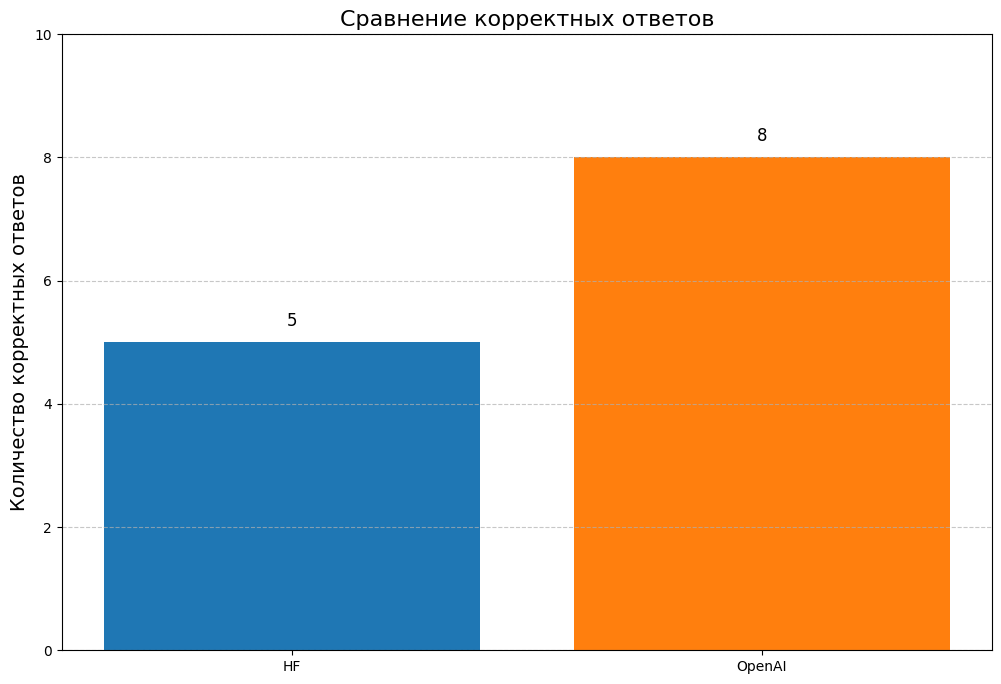

In [77]:
### Задание 2.5: Визуализация сравнения моделей

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

labels = ['HF', 'OpenAI']
values = [hf_correct, openai_correct]
colors = ['#1f77b4', '#ff7f0e']  # Синий и оранжевый

bars = plt.bar(labels, values, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{yval}',
             ha='center', va='bottom', fontsize=12)

plt.title('Сравнение корректных ответов', fontsize=16)
plt.ylabel('Количество корректных ответов', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(values) + 2)

plt.show()

In [ ]:
def create_instruction_dataset(df: pd.DataFrame) -> List[Dict]:
    """
    Создание датасета в формате instruction-following для fine-tuning LLM
    """
    # TODO: Создайте структурированный датасет для fine-tuning LLM
    # Подумайте о структуре instruction-following датасета:
    # - Какие поля должны быть в каждом примере?
    # - Как сформулировать инструкции для модели?
    # - Какие типы задач включить (sentiment, NER, etc.)?
    # - Как структурировать ответы модели?
    #
    # Создайте несколько примеров для разных задач

    pass

# TODO: Протестируйте созданный датасет
# Создайте и проанализируйте instruction dataset
# Выведите примеры в читаемом формате
# Проанализируйте распределение типов задач



### Задание 3.2: Сериализация данных в формате для LLM платформ


In [ ]:
import json

# TODO: Реализуйте сохранение данных в форматах для fine-tuning
# Создайте функции для сохранения данных в форматах:
# 1. JSONL формат для OpenAI fine-tuning API
# 2. CSV формат для общего использования
#
# Изучите требования к форматам:
# - Какая структура нужна для OpenAI fine-tuning?
# - Как правильно структурировать messages?
# - Какие поля обязательны?
#
# Протестируйте сохранение и загрузку данных


